- 아이템 간 연간 관계를 수치화하고 이를 이용한 추천 시스템을 구현합니다.

In [64]:
import requests
from io import BytesIO
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
import scipy
from tqdm.notebook import tqdm
from itertools import combinations
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pickle as pk

plt.style.use("dark_background")

In [2]:
def display_poster(if_item, then_item):
    def get_poster(movie_id):
        url = f"https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/img/POSTER_20M_FULL/{movie_id}.jpg"
        try:
            req = requests.get(url)
            b = BytesIO(req.content)
            img = np.asarray(Image.open(b))
        except:
            img = np.zeros((200, 100, 3))
        return img
    
    def get_movie_title(movie_id):
        global movies_df
        return movies_df.loc[movies_df["id"]==movie_id, "title"].iloc[0]
    
    if_image = get_poster(list(if_item)[0])
    if_title = get_movie_title(list(if_item)[0])
    then_image = get_poster(list(then_item)[0])
    then_title = get_movie_title(list(then_item)[0])

    fig = plt.figure(figsize=(8, 8))
    fig.set_size_inches((20, 5))    
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(f"[antecedent]{if_title}")
    ax.imshow(if_image)

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f"[consequent]{then_title}")
    ax.imshow(then_image)   
    
    plt.tight_layout()  

In [3]:
movies_df = pd.read_csv("movies.csv", index_col=0)
genres_df = pd.read_csv("genres.csv", index_col=0)
ratings_df = pd.read_csv("ratings.csv", index_col=0)

C:\Users\00006363\Anaconda3\envs\tf2.0\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 연관 분석(Association Analysis)
- 대용량의 거래(transaction) 데이터로부터 "X를 구매했으면, Y를 구매할 것이다" 형식의 아이템 간 연관 관계를 분석하는 방법입니다.
- 보통 장바구니 분석(Market Basket Analysis)로 불리기도 합니다. 즉, 고객의 장바구니에 어떤 아이템이 동시 담겼는지 패턴을 파악하여 상품을 추천하는 방법입니다.
### 연관 분석의 주요 지표
- 크게 support, confidence, lift라는 세 가지 지표를 통해 아이템 간의 관계를 표현합니다.
#### Support
- 전체 사용자 중에서 아이템 x를 좋아하는 사용자의 비율
- sup(x) = like(x)/N
#### Confidence
- 아이템 x를 좋아하는 사용자 중에서 아이템 y도 좋아하는 사람의 비율
- conf(x, y) = like(x, y)/like(x)
#### lift
- 전체 사용자들 중 아이템 y를 좋아하는 비율(support)보다 아이템 x를 좋아하는 사용자들 중 아이템 y도 좋아하는 비율(confidence)가 매우 크다면 아이템 x와 y는 매우 연관 관계가 높을 것입니다.
- 반면에 전체 사용자들 중 아이템 y를 좋아하는 비율(support)보다 아이템 x를 좋아하는 사용자들 중 아이템 y도 좋아하는 비율(confidence)이 매우 작다면 아이템 x와 y는 매우 연관 관계가 낮을 것입니다.
- lift(x, y) = conf(x, y)/sup(y)
- lift의 의미는 어떤 사용자가 아이템 x를 좋아한다는 사실이 아이템 y를 좋아할 가능성이 높인다는 의미입니다.

In [4]:
#평점을 4점 이상 주면 그 영화를 좋아하는 것이라고 판단하겠습니다. 평점이 4 이상인 데이터만 선별합니다.
likes_df = ratings_df[ratings_df["rating"]>=4.0]

#사용자별로 좋아하는 영화의 집합을 만듭니다.
baskets = likes_df.groupby("user_id")["movie_id"].apply(set)

In [5]:
baskets.sample(5)

user_id
57168     {3330, 903, 4361, 2572, 55052, 7438, 912, 7823...
90547     {515, 260, 265, 778, 912, 1298, 1175, 924, 541...
123911    {1, 4993, 1923, 5377, 5380, 1542, 647, 648, 10...
18512     {260, 135, 520, 648, 1291, 780, 788, 150, 671,...
119906    {4993, 8961, 33794, 260, 48774, 2571, 6539, 91...
Name: movie_id, dtype: object

- 각각 support, confidence, lift를 계산하는 함수를 만듭니다.

In [6]:
def calc_sup(x):
    likes = baskets[x <= baskets].index
    all_users = set(ratings_df["user_id"])
    return len(likes)/len(all_users)

def calc_conf(x, y):
    likes_x = baskets[x <= baskets].index
    likes_xy = baskets[x|y <= baskets].index
    return len(likes_xy)/len(likes_x)

def calc_lift(x, y):
    return calc_conf(x, y)/calc_sup(y)

In [23]:
print(f"전체 사용자들 중 타이타닉을 좋아하는 사용자의 비율 : {calc_sup({1721}):.3f}")
print(f"스타워즈2를 좋아하는 사용자들 중 타이타닉도 좋아하는 사용자의 비율 : {calc_conf({5378}, {1721}):.3f}")
print(f"스타워즈2를 좋아하는 사용자들 중 스타워즈3도 좋아하는 사용자의 비율 : {calc_conf({5378}, {33493}):.3f}")
print(f"스타워즈2와 타이타닉의 lift : {calc_lift({5378}, {1721}):.3f}")
print(f"스타워즈2와 스타워즈3의 lift : {calc_lift({5378}, {33493}):.3f}")

전체 사용자들 중 타이타닉을 좋아하는 사용자의 비율 : 0.100
스타워즈2를 좋아하는 사용자들 중 타이타닉도 좋아하는 사용자의 비율 : 0.290
스타워즈2를 좋아하는 사용자들 중 스타워즈3도 좋아하는 사용자의 비율 : 0.502
스타워즈2와 타이타닉의 lift : 2.894
스타워즈2와 스타워즈3의 lift : 12.215


# 세 지표를 활용한 추천 알고리즘
1. support와 confidence의 최소 기준을 정하여 그 기준에 미달하는 연관 관계를 제거합니다. support와 confidence가 너무 작으면 lift의 의미가 왜곡되어 해석될 수 있기 때문입니다.
2. lift를 기준으로 연관 관계가 강한 아이템들을 추천합니다.

### 빈발 집합(Frequent Set)
- 빈번하게 등장한 아이템의 쌍을 빈발집합이라고 합니다.
- 연관 분석을 실무에 적용하면, 어떤 아이템 x를 좋아하는 사용자에게 다른 아이템을 추천하기 위해 lift 값을 계산하는 무수히 많은 연산을 수행해야 합니다.
- 이를 해결하기 위한 빈발집합 탐색 알고리즘은 자주 등장하는 아이템의 쌍만을 탐색합니다.
- 대표적으로 Apriori와 Frequent Pattern Growth가 있으며 후자가 전자보다 빠르지만 산출 결과는 동일합니다.

## Apriori Algorithm
- 어떤 아이템 a, b를 모두 좋아하는 사용자의 수가 적다면 sup(a, b)의 값은 작을 것입니다.
- 그렇다면 a, b, c를 모두 좋아하는 사용자의 수는 더 적을 것이므로 sup(a, b, c)는 sup(a, b)보다 작을 것입니다.
- 이때 Apriori Algorithm은 a, b가 모두 포함된 모든 집합에 대해 support를 계산하지 않는 방식으로 연산 부하를 줄입니다.
- 전체 데이터에 대해 빈발집합 탐색 알고리즘을 사용하면 시간이 너무 오래 걸리므로 2015년 기준 10년 내 개봉한 영화만을 고려하도록 합니다.

In [52]:
recent_yr = movies_df["release_year"].max()

recent_movies = movies_df[movies_df["release_year"].isin(range(recent_yr, recent_yr-10, -1))]["id"]

In [51]:
print(f"샘플 갯수 : {len(ratings_df)} -> {len(ratings_df_recent)}({len(ratings_df_recent)/len(ratings_df):.1%})")

샘플 갯수 : 20000263 -> 1679410(8.4%)


### 직접 구현하기

In [20]:
max_len = 3
min_sup = 0.01

# freq_sets = {frozenset((movie, )) for movie in ratings_df["movie_id"]}
freq_sets = {frozenset((movie, )) for movie in [5378, 33493, 68358, 6942, 1721]}

freq_set2sup = {}
for i in range(1, 6):
    #i개 원소를 갖는 frozenset만을 고려합니다.
    freq_sets = list(filter(lambda x : len(x) == i, freq_sets))
    
    #frozsenset:support를 dictionary로 저장합니다.
    freq_set2sup_temp = {}    
    for freq_set in tqdm(freq_sets):
        sup = round(calc_sup(freq_set), 3)
        #min_sup보다 support가 높은 frozenset만을 선별합니다.
        if sup >= min_sup:
            freq_set2sup_temp[freq_set] = sup
            print(freq_set, sup)
            
    freq_set2sup.update(freq_set2sup_temp)
    #원소 2개의 조합으로 만들 수 있는 모든 합집합을 만듭니다.
    freq_sets = {a | b for a, b in combinations(freq_set2sup.keys(), 2)}

In [22]:
freq_set2sup

{frozenset({33493}): 0.041,
 frozenset({1721}): 0.1,
 frozenset({68358}): 0.038,
 frozenset({6942}): 0.037,
 frozenset({5378}): 0.037,
 frozenset({1721, 33493}): 0.012,
 frozenset({33493, 68358}): 0.01,
 frozenset({5378, 33493}): 0.019,
 frozenset({1721, 5378}): 0.011,
 frozenset({1721, 6942}): 0.011}

### Mlxtend Library로 구현하기

In [56]:
#각 영화를 좋아하는지 여부를 dataframe 형태로 만드는 multi-hot encoding을 수행합니다.
baskets_recent = baskets[baskets.index.isin(recent_movies)]
te = TransactionEncoder()
baskets_te = te.fit_transform(baskets_recent)

baskets_df = pd.DataFrame(baskets_te, index=baskets_recent.index, columns=te.columns_)

In [57]:
baskets_df

1       2       3       4       5       6       7       8       \
user_id                                                                   
27904     False   False   False   False   False   False   False   False   
38188     False   False   False   False   False   False   False   False   
41863     False   False   False   False   False   False   False   False   
42725     False   False   False   False   False   False   False   False   
42728     False   False   False   False   False   False   False   False   
...         ...     ...     ...     ...     ...     ...     ...     ...   
131239    False   False   False   False   False   False   False   False   
131248    False   False   False   False   False   False   False   False   
131254     True   False   False   False   False   False   False   False   
131258     True   False   False   False   False   False   False   False   
131262    False   False   False   False   False   False   False   False   

         9       10      ...  131158  131160  131239  131241  131243  131248  \
user_id                  ...                                                   
27904     False   False  ...   False   False   False   False   False   False   
38188     False   False  ...   False   False   False   False   False   False   
41863     False   False  ...   False   False   False   False   False   False   
42725     False   False  ...   False   False   False   False   False   False   
42728     False   False  ...   False   False   False   False   False   False   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
131239    False   False  ...   False   False   False   False   False   False   
131248    False   False  ...   False   False   False   False   False   False   
131254    False   False  ...   False   False   False   False   False   False   
131258    False   False  ...   False   False   False   False   False   False   
131262    False   False  ...   False   False   False   False   False   False   

         131250  131252  131254  131256  
user_id                                  
27904     False   False   False   False  
38188     False   False   False   False  
41863     False   False   False   False  
42725     False   False   False   False  
42728     False   False   False   False  
...         ...     ...     ...     ...  
131239    False   False   False   False  
131248    False   False   False   False  
131254    False   False   False   False  
131258    False   False   False   False  
131262    False   False   False   False  

[8722 rows x 11535 columns]

In [71]:
#freq_sets_df를 .pk로 저장한 파일이 있으면 불러오고 없으면 시행 후 저장합니다.
file = "freq_sets_df.pk"
if os.path.exists(file):
    with open(file, "rb") as f:
        freq_sets_df = pk.load(f)
else:
    with open(file, "wb") as f:
        freq_sets_df = apriori(baskets_df.sample(frac=0.05), min_support=0.01, max_len=2, use_colnames=True, verbose=1)
        
        pk.dump(freq_sets_df, f)

In [72]:
freq_sets_df

support          itemsets
0       0.231651               (1)
1       0.050459               (2)
2       0.027523               (3)
3       0.022936               (5)
4       0.094037               (6)
...          ...               ...
131159  0.018349   (99114, 102445)
131160  0.011468   (103042, 99114)
131161  0.013761   (104841, 99114)
131162  0.013761  (102125, 102445)
131163  0.013761  (103042, 102125)

[131164 rows x 2 columns]

## 연관 분석 수행하기

In [75]:
#support>0.01인 경우만 선별합니다.
asso_rules = association_rules(freq_sets_df, metric="support", min_threshold=0.01)
#confidence>0.1인 경우만 선별합니다.
asso_rules = asso_rules[asso_rules["confidence"]>0.1]
asso_rules = asso_rules.sort_values("lift", ascending=False)

In [78]:
#movie_id:title의 dictionary
id2title = dict(zip(movies_df["id"], movies_df["title"]))

#영화 제목을 column으로 추가합니다.
asso_rules.insert(2, "antecedents_title", asso_rules["antecedents"].apply(lambda x : id2title[list(x)[0]]))
asso_rules.insert(3, "consequents_title", asso_rules["consequents"].apply(lambda x : id2title[list(x)[0]]))

In [79]:
asso_rules

antecedents consequents        antecedents_title  \
256919     (68159)     (62374)            State of Play   
257029     (68159)     (63113)            State of Play   
256918     (62374)     (68159)             Body of Lies   
257028     (63113)     (68159)        Quantum of Solace   
258657     (86377)     (86345)    Louis C.K.: Shameless   
...            ...         ...                      ...   
66580        (588)      (2959)                  Aladdin   
15930         (62)      (2959)       Mr. Holland's Opus   
42248        (339)      (1198)  While You Were Sleeping   
15851         (62)      (1196)       Mr. Holland's Opus   
15927         (62)      (2858)       Mr. Holland's Opus   

                                        consequents_title  antecedent support  \
256919                                       Body of Lies            0.013761   
257029                                  Quantum of Solace            0.013761   
256918                                      State of Play            0.011468   
257028                                      State of Play            0.011468   
258657                              Louis C.K.: Hilarious            0.013761   
...                                                   ...                 ...   
66580                                          Fight Club            0.181193   
15930                                          Fight Club            0.091743   
42248   Raiders of the Lost Ark (Indiana Jones and the...            0.087156   
15851      Star Wars: Episode V - The Empire Strikes Back            0.091743   
15927                                     American Beauty            0.091743   

        consequent support   support  confidence       lift  leverage  \
256919            0.011468  0.011468    0.833333  72.666667  0.011310   
257029            0.011468  0.011468    0.833333  72.666667  0.011310   
256918            0.013761  0.011468    1.000000  72.666667  0.011310   
257028            0.013761  0.011468    1.000000  72.666667  0.011310   
258657            0.013761  0.011468    0.833333  60.555556  0.011279   
...                    ...       ...         ...        ...       ...   
66580             0.236239  0.022936    0.126582   0.535824 -0.019869   
15930             0.236239  0.011468    0.125000   0.529126 -0.010205   
42248             0.252294  0.011468    0.131579   0.521531 -0.010521   
15851             0.261468  0.011468    0.125000   0.478070 -0.012520   
15927             0.291284  0.011468    0.125000   0.429134 -0.015255   

        conviction  
256919    5.931193  
257029    5.931193  
256918         inf  
257028         inf  
258657    5.917431  
...            ...  
66580     0.874452  
15930     0.872870  
42248     0.860995  
15851     0.844037  
15927     0.809961  

[224915 rows x 11 columns]

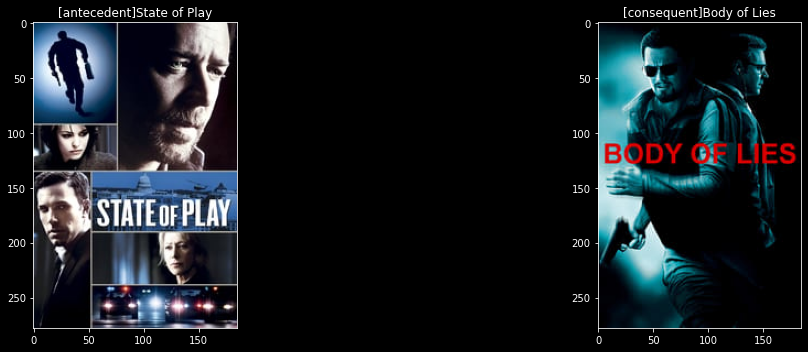

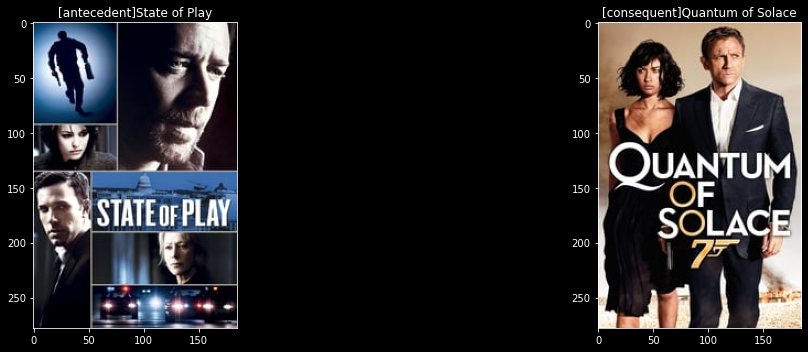

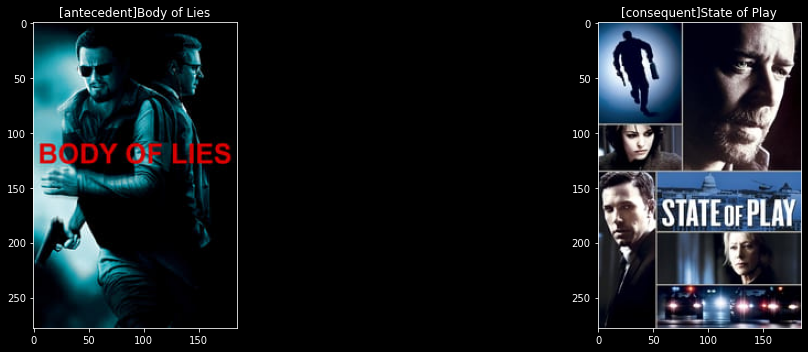

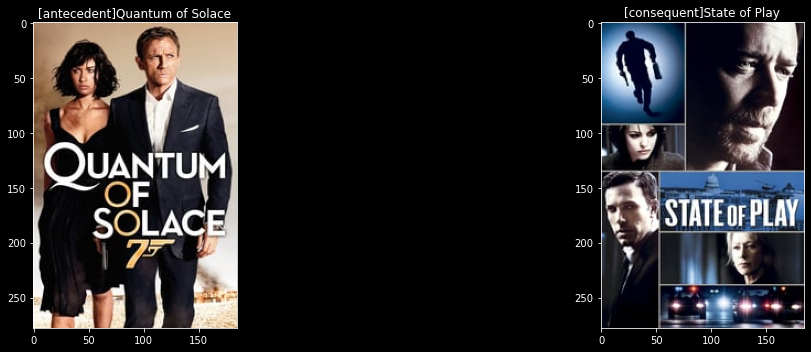

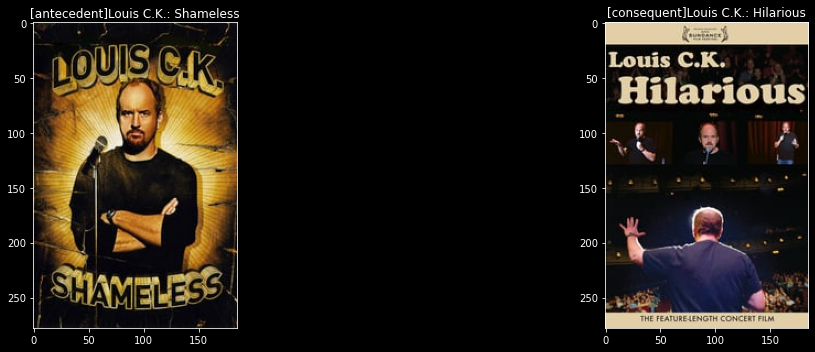

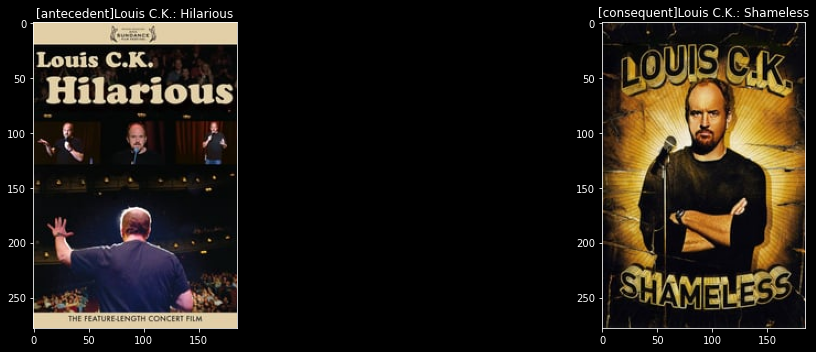

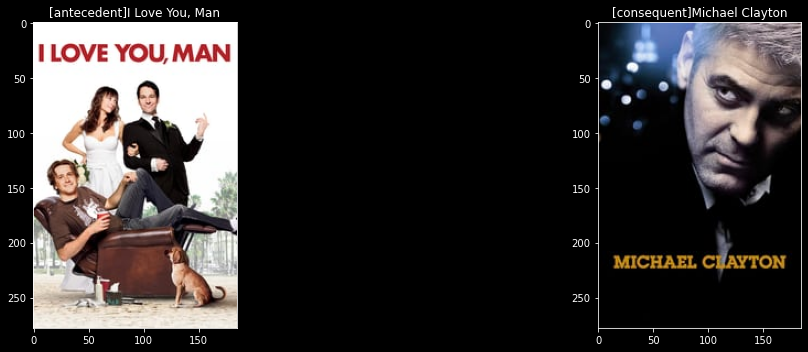

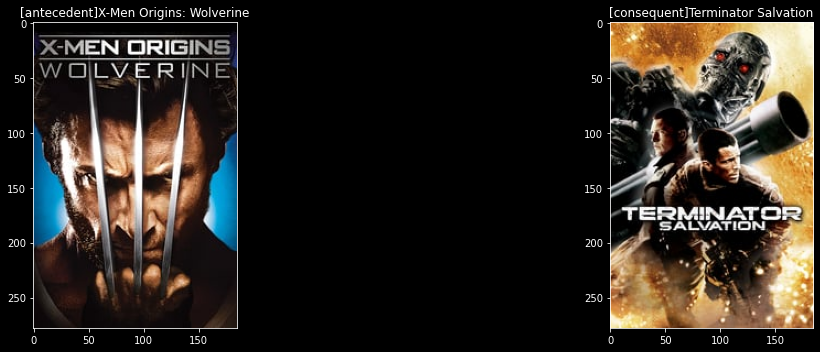

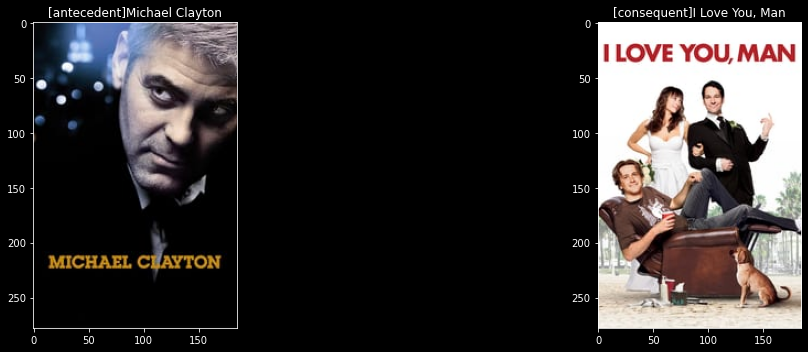

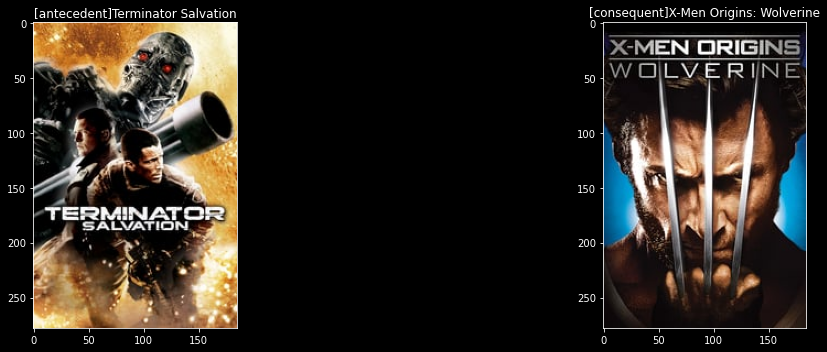

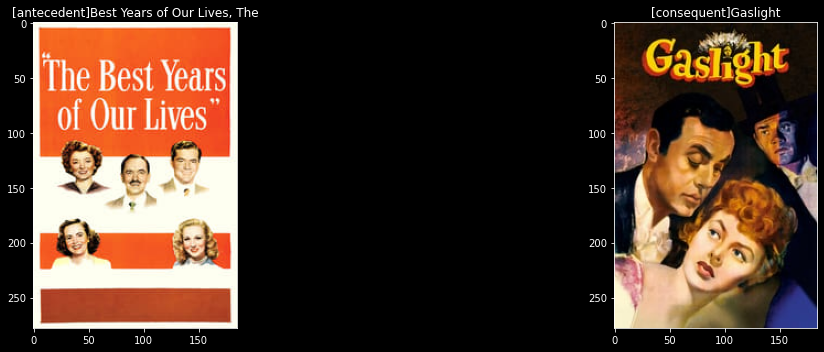

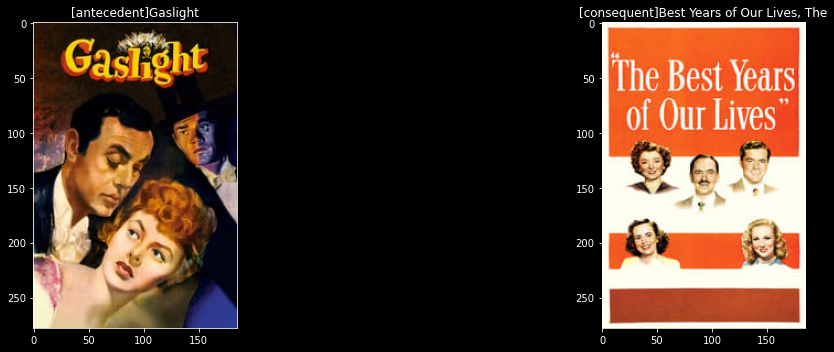

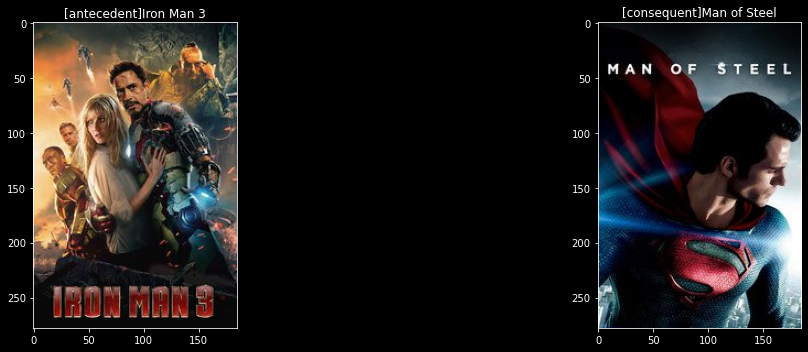

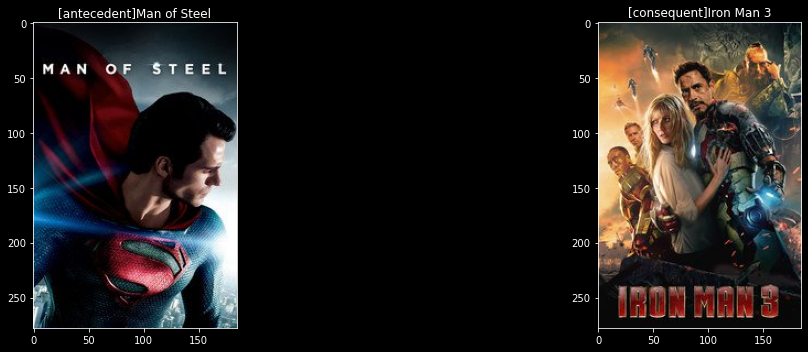

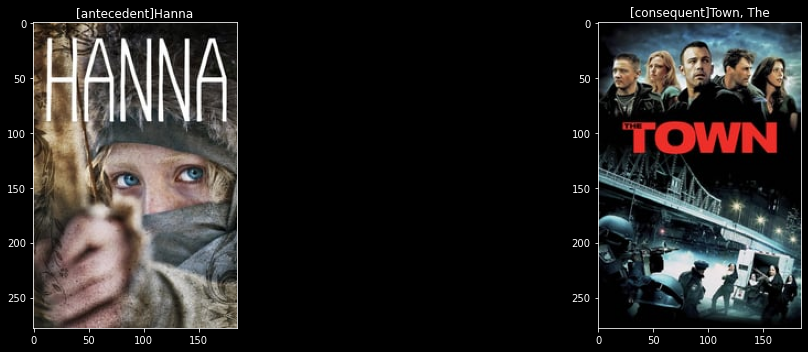

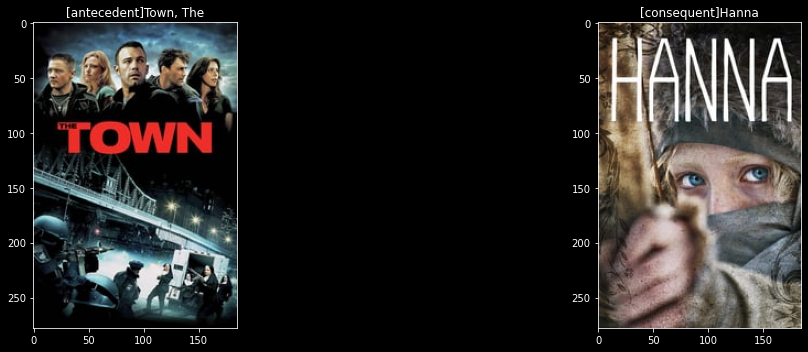

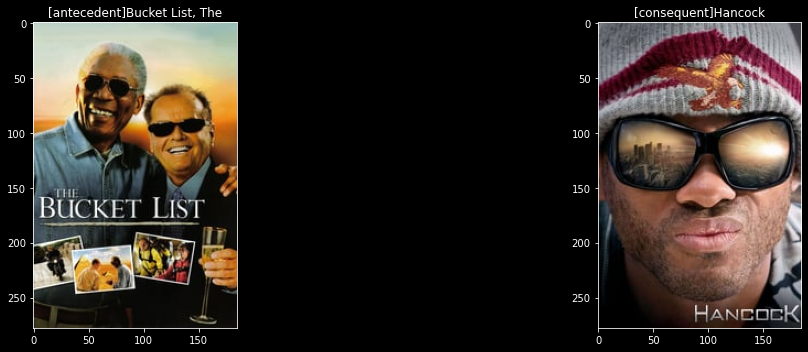

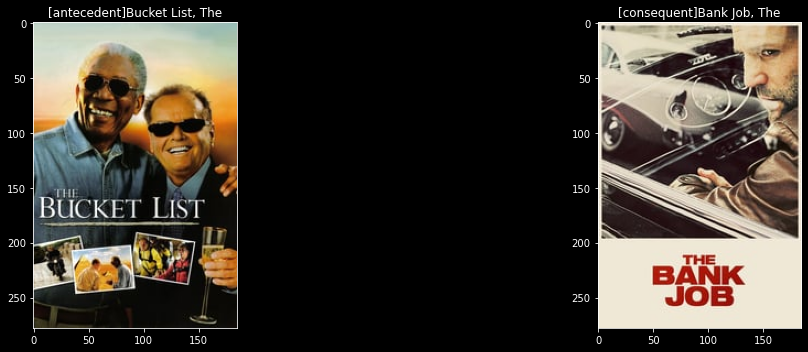

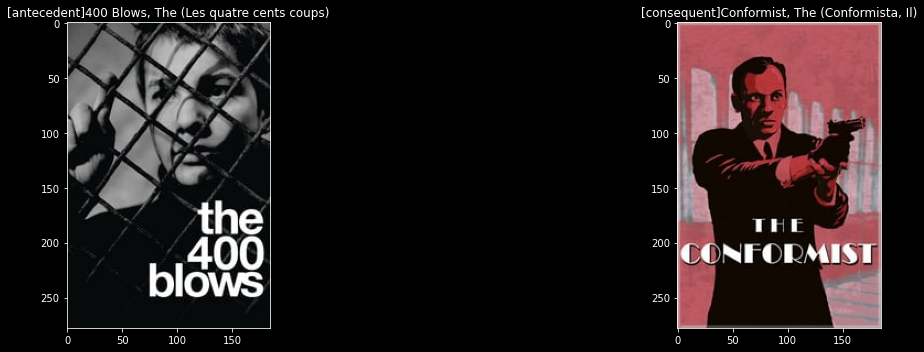

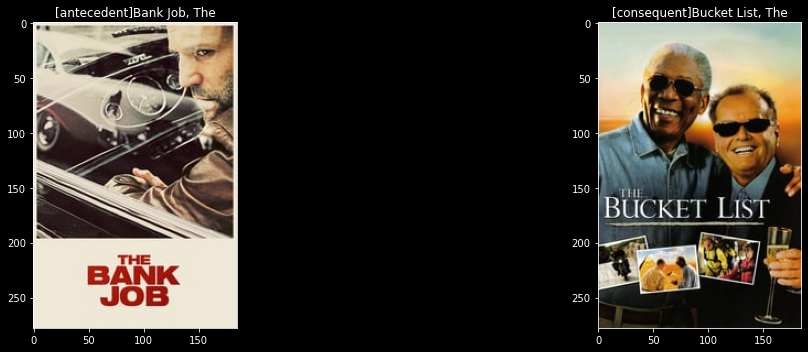

In [80]:
for _, row in asso_rules[:20].iterrows():
    display_poster(row["antecedents"], row["consequents"])